# Regresión logística para varias clases

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import Image  # Esto es para desplegar imágenes en la libreta

## 1. La base de datos a utilizar

La regresión *softmax* (o tambien conocida como *regresión logística multinomial*) es el último de los algoritmos basado en modelos lineales generalizados que cubriremos en el curso de reconocimiento de patrones. Para ejemplificar su uso, vamos a utilizar una base de datos bastante comun, MNIST. 

MNIST es una base de datos de digitos escritos a mano, en formato de $20 \times 20$ pixeles. La base completa puede obtenerse en la página de Yan LeCun (http://yann.lecun.com/exdb/mnist/).

Nosotros en realidad vamos a utilizar una base de datos reducida de la original y con imágenes de calidad más reducida ($16 \times 16$ pixeles por imagen). Numpy provée un método para guardad objetos tipo numpy en un solo archivo, utilizando el método de compresión *gunzip*. Los datos ya se encuentran preprocesados y empaquetados en un archivo llamado `digitos.npz`. 

In [2]:
data = np.load("digitos.npz")

print data.keys()

['X_valida', 'X_entrena', 'T_valida', 'T_entrena']


En este caso, `data` es un objeto contenedor de numpy cuyas llaves son `X_valida`, `X_entrena`, `T_valida`, `T_entrena`. Cada una de estas son a su vez objetos tipo ndarray de numpy, los cuales contienen valores de entrada y salida, tantopara entrenamiento como para validación. No se preocupen, esto de entrenamiento y validación lo vamos a ver más adelante en la clase.

Cada renglon de x es una imagen *desenrrollada*, esto es los 256 datos de una imágen de $16 \times 16$ pixeles. Por otra parte, cada renglon de y es un vector de 10 posiciones, donde todos los valores son ceros, salvo uno, que es el que define la clase de la imagen.

Para darse una mejor idea, ejecuta el siguiente script varias veces.

-- x es de dimensiones  (9000L, 256L)
-- y es de dimensiones  (9000L, 10L)

y si escogemos la imagen  2421 veremos


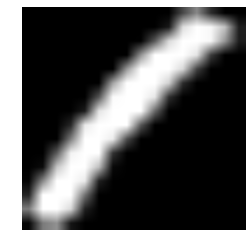

la cual es un 1


Y si miramos lo que contiene, veremos que
x[a,:] = 
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.28235295  0.52941179
  0.17647059  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.09803922  0.86666673  1.          0.96862751  0.75686282  0.11764707
  0.          0.          0.          0.          0.          0.          0.
  0.          0.00392157  0.34901962  0.85098046  1.          1.
  0.96862751  0.58823532  0.1137255   0.          0.          0.          0.
  0.          0.          0.          0.          0.57647061  1.          1.
  1.          0.89019614  0.23529413  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.60000002
  1.          1.          1.          0.84705889  0.25490198  0.          0.
  0.          0.          0.          0.  

In [3]:
x = data['X_entrena']
y = data['T_entrena']

a = np.random.randint(0, y.shape[0])

print "-- x es de dimensiones ", x.shape
print "-- y es de dimensiones ", y.shape

print "\ny si escogemos la imagen ", a, "veremos"

plt.imshow(x[a,:].reshape(16,16), cmap=plt.gray())
plt.axis('off')
plt.show()

print "la cual es un", list(y[a,:]).index(1)

print"\n\nY si miramos lo que contiene, veremos que"
print"x[a,:] = "
print x[a,:]
print "y[a,:] = "
print y[a,:]

O bien, ejecuta este script para ver un grupo grande de imágenes (puedes hacer más grande la imagen para verla mejor).

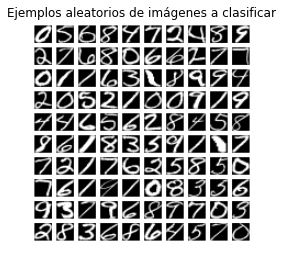

In [4]:
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
ind = indices[0:100].reshape(10,10)

imagen = np.ones((10 * 16 + 4*11, 10 * 16 + 4*11))
for i in range(10):
    for j in range(10):
        imagen[4 + i * 20: 20 + i * 20, 4 + j * 20: 20 + j * 20] = x[ind[i, j], :].reshape(16,16)
        
plt.imshow(imagen, cmap=plt.gray())
plt.axis('off')
plt.title(u"Ejemplos aleatorios de imágenes a clasificar")


Por último, vamos a hacer una función que agregue la columna de unos para la x extendida, y simplificar más adelante su uso.

In [5]:
def extendida(x):
    """
    Agrega una columna de unos a x
    
    """
    return np.c_[np.ones((x.shape[0], 1)), x]

## 2. Regresión logística para varias clases

En la regresión logistica para varias clases, en lugar de estimar solamente un vector de parámetros, el valor de salida lo descomponemos en $K$ vectores de salida con valores de 1 (sipertenece a esa clase) o cero (si no pertenece). A esto se le conoce como *dummy variable*. En el ejemplo que tenemos, las clases ya se encuentran de esa forma (por eso la salida es un vector de dimensión 10 donde solo uno es 1 y todos los demás valores son 0).  Lo que tenemos que hacer es estimar una matriz de parámetros $\omega$ tal que:

$$
\omega = (\omega^{(1)}, \ldots, \omega^{(K)}) 
$$

donde $\omega^{(k)} = (\theta_0^{(k)}, \ldots, \omega_n^{(k)})^T$ es el vector columna que parametriza la clase $k$. De esta manera, $\omega$ es ahora una matriz de dimensión $n+1 \times K$. El aporte lineal a cada clase de un objeto $x^(i)$ está dado por

$$
z^{i} = \omega^T x^{(i)},
$$

el cual es de dimensión $K \times 1$ (un valor por cada clase). La probabilidad de pertenecer a la clase $k$ respecto al resto de las clases está dada por:

$$
\hat{y}_k^{(i)} = logistica(z^{(i)}) = \frac{1}{1 + \exp(-z^{(i)})}.
$$

Como se puede ver, $\hat{y}^{(i)}$ es independiente para cada posible valor de $k$, por lo que la suma no está condicionada a ser 1.

#### Ejercicio 1. Con esta información, realiza la función *logistica*, de manera que si recibe un ndarray de dimensiones $ T \times K$ con $T$ vectores, regrese la matriz de mismas dimensiones con el cálculo *logistica* para cada matriz (20 puntos).

In [6]:
def logistica(z):
    """
    Calculo de la regresión softmax
    
    @param z: ndarray de dimensión (T, K) donde z[i, :] es el vector de aportes lineales de el objeto i
    
    @return: un ndarray de dimensión (T, K) donde cada columna es el calculo softmax de su respectivo vector de entrada.
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    T, K = z.shape
    M = np.exp(z)
    for i in range(T):
        suma = np.sum(M[i])
        for j in range(K):
            M[i][j] = M[i][j]/suma
    return M
    
    
    #--------------------------------------------------------------------------------


Y ahora es necesario implementar la función de costo, la cual es la suma de los costos por cada salida de las k regresiones logísticas, la cual puede resumirse como:

$$
J(\theta) = -\frac{1}{T}\sum_{i=1}^T \sum_{k=1}^K y_k^{(i)} \log(\hat{y}_k^{(i)}),
$$

donde $y_k^{(i)}$ es un valor de 0 o 1 dependiendo si el objeto $i$ pertenece a la clase $k$ o no, mientras que $\hat{y}_k^{(i)}$ es la probabilidad que el objeto $i$ pertenezca a la clase $k$ conociendo $x^{(i)}$ y parametrizado por $\omega$. Esto se vio en clase y no se realizará el repaso aqui en la libreta.

#### Ejercicio 2. Implementa la función de costo de manera relativamente eficiente, utilizando las facilidades que presenta numpy (20 puntos)

In [7]:
def costo(w, x, y):
    """
    Calcula el costo para la regresión softmax parametrizada por theta, 
    con el conjunto de datos dado por (x, y)
    
    @param w: ndarray de dimensión (n+1, K) con los parámetros
    @param x: ndarray de dimensión (T, n+1) con los datos
    @param y: ndarray de dimensión (T, K) con la clase por cada dato
    
    @return: Un valor flotante
    
    """
    T, K = y.shape
    n = x.shape[1] - 1
    
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------

    return -(np.sum(y*np.log(logistica(x.dot(w)))))/T



    #--------------------------------------------------------------------------------

def test_costo():
    x = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    y = np.eye(4)

    w = np.array([[3, -4, -4],[-1, -1, 3], [.01, 3, -10], [-5, 5, 5]]).T
    
    assert costo(w, x, y) < 0.1
    return "Paso la prueba"
    
print test_costo()

Paso la prueba


#### Ejercicio 3. Implementa la función para predecir el valor de y estimada sin tener que calcular la función softmax (20 puntos)

In [8]:
def predice(w, x):
    """
    Prediccion de y_hat a partir de la matriz theta para los valores de x
    
    @param w: ndarray de dimensión (n+1, K) con los parámetros
    @param x: ndarray de dimensión (T, n+1) con los datos

    @return: ndarray de dimensión (T, K) con la clase por cada dato (unos y ceros)
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------

    indices = np.argmax(x.dot(w), axis = 1)
    y_est = np.zeros((x.shape[0],w.shape[1]))
    for i in range(y_est.shape[0]):
        y_est[i][indices[i]] = 1
    return y_est


    #--------------------------------------------------------------------------------

def prueba_prediccion():
    x = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    y = np.eye(4)

    w = np.array([[3, -4, -4],[-1, -1, 3], [.01, 3, -10], [-5, 5, 5]]).T
    
    assert abs((y - predice(w, x)).sum()) < 1e-12 
    print "Paso la prueba"
    
print prueba_prediccion()

Paso la prueba
None


Y por último tenemos que implementar el gradiente para poder utilizar los métodos de optimización (ya sea por descenso de gradiente o por algún método de optimización.

El gradiente se obtiene a partir de las derivadas parciales:

$$
\frac{\partial J(\omega)}{\partial \omega_s^{(r)}} = - \frac{1}{T} \sum_{i = 1}^T \left(y_k^{(i)} -  \sum_{j=1}^K \hat{y}_j^{i}\right) x_s^{(i)},
$$

donde $k$ es la clase a la que pertenece el ejemplo $i$. Esto implica que cuando $k = r$, entonces solamente tenemos $1 - \hat{y}_k^{(i)}$ para este dato. Si $k \neq r$ entonces tendremos $-\hat{y}_r^{(i)}$. 

Esto se puede resolver en forma matricial como

$$
\nabla J(\theta) = - \frac{1}{T} X^T (Y - \hat{Y})
$$


#### Ejercicio 4. Implementa el gradiente de la manera que menos se dificulte (15 puntos)

In [15]:
def gradiente(w, x, y):
    """
    Calculo del gradiente para el problema de regresión softmax
    
    @param w: ndarray de dimensión (n+1, K) con los parámetros
    @param x: ndarray de dimensión (T, n+1) con los datos
    @param y: ndarray de dimensión (T, K) con la clase por cada dato
    
    @return: Un ndarray de mismas dimensiones que theta
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------

    T, K = y.shape
    return  -(x.T.dot(y-(logistica(x.dot(w)))))/T
    
    

    
    #--------------------------------------------------------------------------------

def prueba_gradiente():
    x = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    y = np.eye(4)

    w = np.array([[3, -4, -4],[-1, -1, 3], [.01, 3, -10], [-5, 5, 5]]).T
    #profesor tenia un error de que no existia g, pero lo pude 
    #solucionar comparandolo con la tarea de regresion del 
    #semestre pasado
    g = gradiente(w, x, y)
    print np.abs(g).max()
    assert np.abs(g).max() < 0.05
    
    print "Paso la prueba"
    
print prueba_gradiente()    
    
    

0.0355909430876
Paso la prueba
None


Ahora si, ya nos encontramos en capacidad para realizar el aprendizaje para la regresión logística.

#### Ejercicio 5. Implementa la regresión logística utilizando el método de descenso de gradiente (15 puntos)

In [10]:
def dg_logistica_lotes(w, x, y, alpha=None, max_epoch=10000, epsilon=1e-3, errores=False):
    """
    Descenso de gradiente por lotes para la clasificación softmax
    
    """
    historial = np.zeros((max_epoch)) if errores else None
        
    for epoch in xrange(max_epoch):
        #--------------------------------------------------------------------------------
        # AGREGA AQUI TU CÓDIGO
        #--------------------------------------------------------------------------------
        grad = gradiente(w, x, y)
        
        w += -alpha*grad
        cost = costo(w, x, y)
        
        if(errores):
            historial[epoch] = cost

        if(np.linalg.norm(grad) <= epsilon):
           return w, historial


        #--------------------------------------------------------------------------------
    return w, historial
        
    

Pero para utilizar el descenso de gradiente hay que ajustar un valor de $\alpha$.

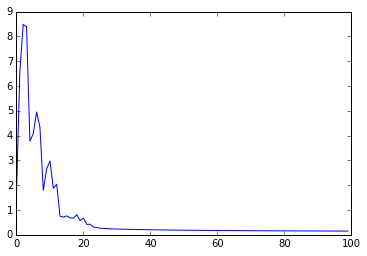

In [11]:
# Ajusta un valor de alpha razonable

alfita = 5

T, K = y.shape
n = x.shape[1]

w = 0.1 * (np.random.random((n + 1, K)) - 0.5)
w, e_hist = dg_logistica_lotes(w, extendida(x), y, alpha=alfita, max_epoch=100, errores=True)
plt.plot(e_hist)



y para probarlo vamos a aprender a clasificar a los digitos de nuestra base de datos


In [ ]:
w = 0.1 * (np.random.random((n + 1, K)) - 0.5)
w, e_hist = dg_logistica_lotes(w, extendida(x), y, alpha=alfita, max_epoch=1000)

print "El costo de la solución final es de ", costo(w, extendida(x), y)

y_estimada = predice(w, extendida(x))
errores = np.where(y.argmax(axis=1) == y_estimada.argmax(axis=1), 0, 1)

print "\nLos datos utilizados para el aprendizaje mal clasificados son el ", 100 * errores.mean(),"%"

# Esto solo es para hacerla más emocionante
x_test = data['X_valida']
y_test = data['T_valida']
y_estimada_T = predice(theta, extendida(x_test))
errores = np.where(y_test.argmax(axis=1) == y_estimada_T.argmax(axis=1), 0, 1)

print "\nY con los datos de pureba el error es del ", 100 * errores.mean(),"%"


¿Será esta la mejor solución? ¿Será una buena solución? Por esto no hay que preocuparse mucho todavía, lo vamos a revisar más adelante en el curso. Se espera con la regresión en varias clases poder clasificar correctamente más del 95% de los datos de entrenamiento. 